In [1]:
import os
import sys
import random
import warnings
from pylab import imshow, show, get_cmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, UpSampling2D, Flatten, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
#from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras import backend as K
import tensorflow as tf
import skimage
from PIL import Image

In [20]:
import shutil

# Path of the file
filename = "/content/forest.zip"

# Target directory
extract_dir = "/content/kaggle"

# Unzip the file
shutil.unpack_archive(filename, extract_dir)

ReadError: ignored

In [4]:
img_width = img_height = 160
img_channel = 3
input_shape = (img_height,img_width,img_channel)

_, _, files = next(os.walk("/content/kaggle/forest/"))
len(files)

2512

In [5]:
xtrain = np.zeros((len(files),img_height,img_width,img_channel), dtype='float32')
xtrain.shape

(2512, 160, 160, 3)

In [6]:
path = '/content/kaggle/forest'
count=0
for image_path in os.listdir(path):
    try:
        input_path = os.path.join(path, image_path)
        img = Image.open(input_path)
        img = img.resize((img_height,img_width))
        img = np.array(img)
        img = img.astype('float32') / 255.
        xtrain[count] = img
        count += 1
    except:
        pass

In [7]:
xtrain.shape

(2512, 160, 160, 3)

In [8]:
input_layer = Input(shape = input_shape)

def encoder(inp):
    x = Conv2D(128, (4, 4), activation='elu', padding='same',name='encode1')(inp)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode2')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode3')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode4')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode5')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode6')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode7')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode8')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',name='encode9')(x)
    x = Flatten()(x)
    x = Dense(1600, activation='elu',name='encode10')(x)
    enc = Dense(400, activation='sigmoid',name='encode11')(x)
    return Model(input_layer,enc,name = 'Encoder_Circuit')

encoder(input_layer).summary()

Model: "Encoder_Circuit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 encode1 (Conv2D)            (None, 160, 160, 128)     6272      
                                                                 
 encode2 (Conv2D)            (None, 160, 160, 64)      73792     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 64)       0         
 )                                                               
                                                                 
 encode3 (Conv2D)            (None, 80, 80, 64)        36928     
                                                                 
 encode4 (Conv2D)            (None, 80, 80, 32)        8224      
                                                   

In [9]:
input_layer = Input(shape = [400])

def decoder(inp):
    x = Dense(1600, activation='elu', name='decode1')(inp)
    x = Dense(3200, activation='elu', name='decode2')(x)
    x = Reshape((10, 10, 32))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode7')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode8')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode9')(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode10')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode11')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode12')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same', name='decode13')(x)
    x = Conv2D(16, (2, 2), activation='elu', padding='same', name='decode14')(x)
    denc = Conv2D(3, (2, 2), activation='sigmoid', padding='same', name='decode15')(x)
    return Model(input_layer,denc,name = 'Decoder_Circuit')

decoder(input_layer).summary()

Model: "Decoder_Circuit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400)]             0         
                                                                 
 decode1 (Dense)             (None, 1600)              641600    
                                                                 
 decode2 (Dense)             (None, 3200)              5123200   
                                                                 
 reshape (Reshape)           (None, 10, 10, 32)        0         
                                                                 
 decode3 (Conv2D)            (None, 10, 10, 32)        4128      
                                                                 
 decode4 (Conv2D)            (None, 10, 10, 64)        18496     
                                                                 
 up_sampling2d (UpSampling2D  (None, 20, 20, 64)   

In [10]:
from keras.layers import LeakyReLU

input_layer = Input(shape = input_shape)

def Autoencoder(inp):
    # Encoding
    x = Conv2D(128, (4, 4), activation='elu', padding='same',name='encode1')(inp)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode2')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode3')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode4')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode5')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode6')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode7')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode8')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',name='encode9')(x)
    x = Flatten()(x)
    x = Dense(1600, activation='elu',name='encode10')(x)
    enc = Dense(400, activation='sigmoid',name='encode11')(x)

    # Decoding
    x = Dense(1600, activation='elu', name='decode1')(enc)
    x = Dense(3200, activation='elu', name='decode2')(x)
    x = Reshape((10, 10, 32))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode7')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode8')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode9')(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode10')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode11')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode12')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same', name='decode13')(x)
    x = Conv2D(16, (2, 2), activation='elu', padding='same', name='decode14')(x)
    denc = Conv2D(3, (2, 2), activation='sigmoid', padding='same', name='decode15')(x)

    return Model(input_layer,denc,name = 'Autoencoder_Circuit')

model = Autoencoder(input_layer)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "Autoencoder_Circuit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 encode1 (Conv2D)            (None, 160, 160, 128)     6272      
                                                                 
 encode2 (Conv2D)            (None, 160, 160, 64)      73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 80, 80, 64)       0         
 2D)                                                             
                                                                 
 encode3 (Conv2D)            (None, 80, 80, 64)        36928     
                                                                 
 encode4 (Conv2D)            (None, 80, 80, 32)        8224      
                                               

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
filepath = "Auto_ED_Model.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=8,
                              verbose=1,
                              mode='min',
                              restore_best_weights=True)


"\nearly_stopping = EarlyStopping(monitor='val_loss',\n                              patience=8,\n                              verbose=1,\n                              mode='min',\n                              restore_best_weights=True)\n"

In [18]:
class ImgSample(Callback):

    def __init__(self):
       super(Callback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        sample_img = xtrain[50]
        sample_img = sample_img.reshape(1,img_height,img_width,img_channel)
        sample_img = self.model.predict(sample_img)[0]
        imshow(sample_img)
        plt.show()

imgsample = ImgSample()

In [13]:
xtrain.shape

(2512, 160, 160, 3)

(2512, 160, 160, 3)
Epoch 1/100
1/1 [==============================] - 0s 31ms/step


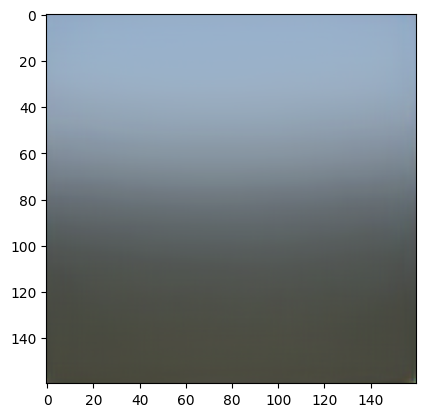

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 421ms/step
Epoch 2/100
1/1 [==============================] - 0s 25ms/step


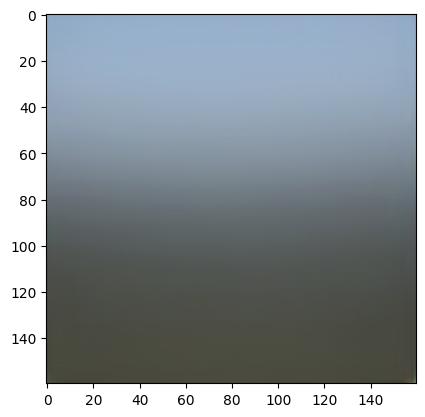

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 426ms/step
Epoch 3/100
1/1 [==============================] - 0s 20ms/step


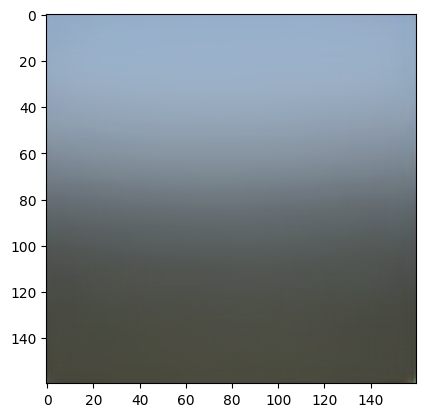

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 428ms/step
Epoch 4/100
1/1 [==============================] - 0s 20ms/step


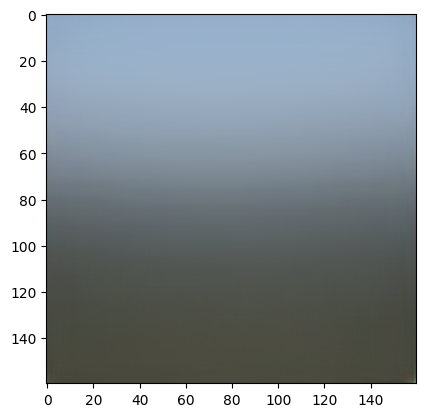

75/75 - 33s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 33s/epoch - 438ms/step
Epoch 5/100
1/1 [==============================] - 0s 20ms/step


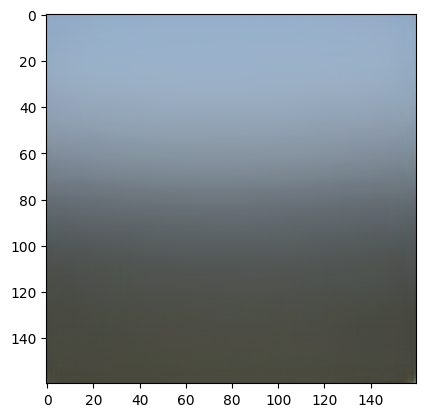

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 427ms/step
Epoch 6/100
1/1 [==============================] - 0s 20ms/step


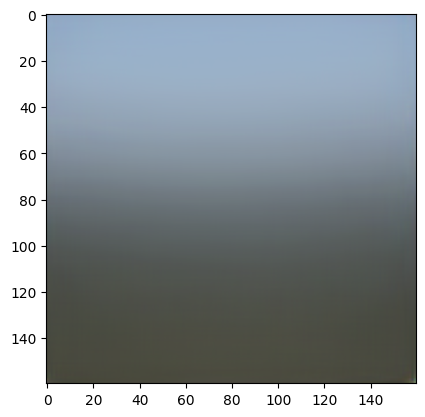

75/75 - 33s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 33s/epoch - 435ms/step
Epoch 7/100
1/1 [==============================] - 0s 20ms/step


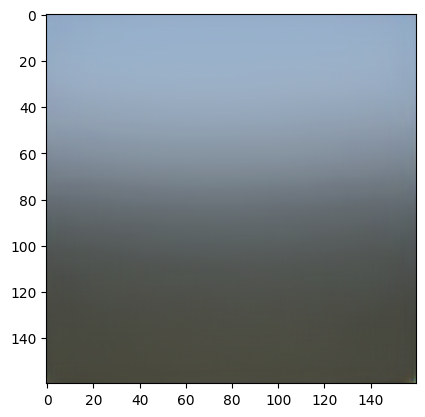

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 8/100
1/1 [==============================] - 0s 20ms/step


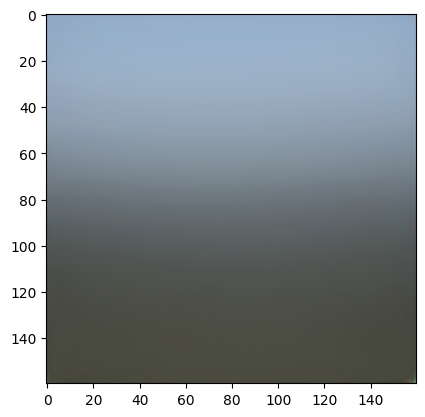

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 9/100
1/1 [==============================] - 0s 20ms/step


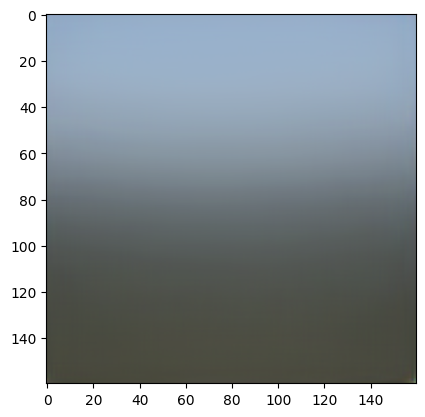

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 428ms/step
Epoch 10/100
1/1 [==============================] - 0s 22ms/step


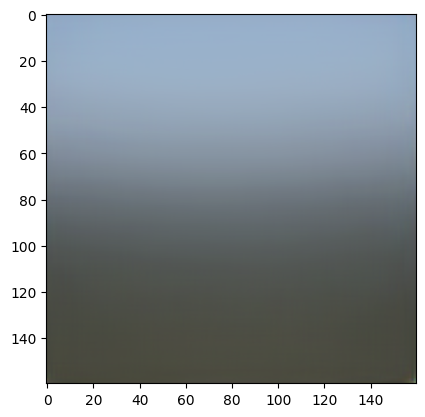

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 11/100
1/1 [==============================] - 0s 20ms/step


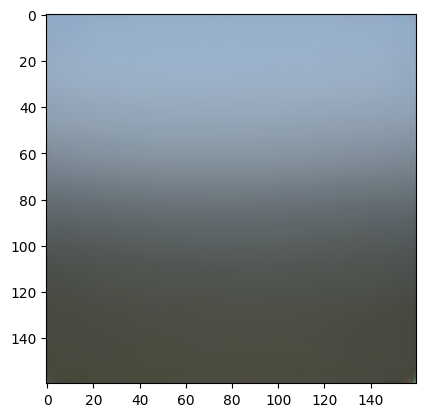

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 12/100
1/1 [==============================] - 0s 35ms/step


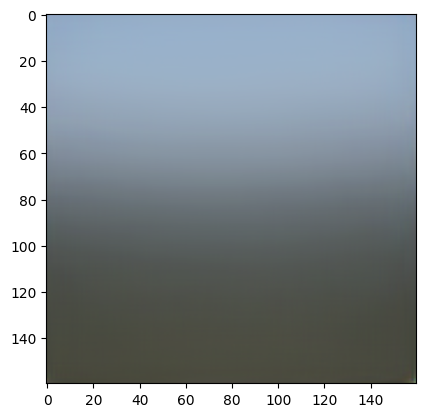

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 13/100
1/1 [==============================] - 0s 20ms/step


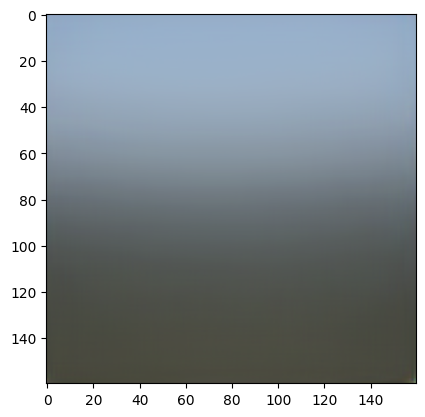

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 14/100
1/1 [==============================] - 0s 20ms/step


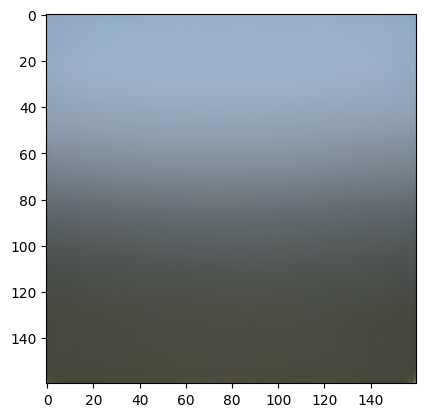

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 15/100
1/1 [==============================] - 0s 29ms/step


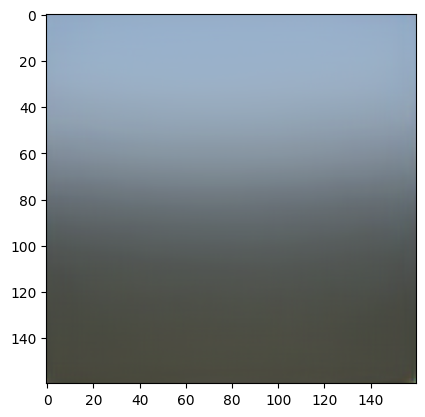

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 16/100
1/1 [==============================] - 0s 22ms/step


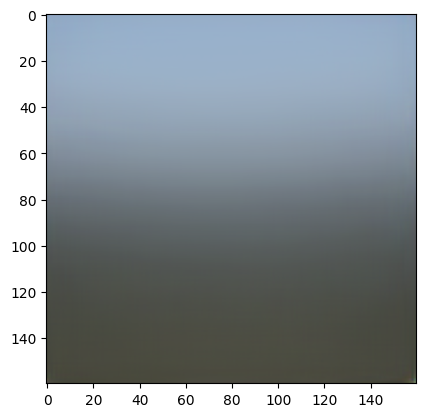

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 17/100
1/1 [==============================] - 0s 21ms/step


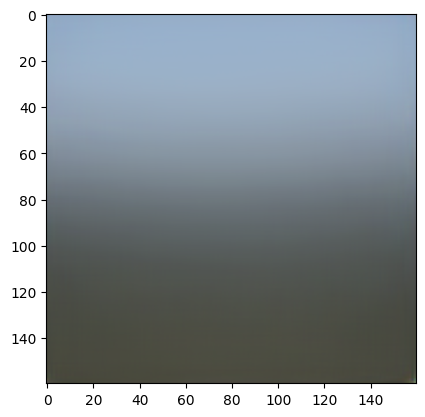

75/75 - 36s - loss: 0.0509 - val_loss: 0.0504 - lr: 1.0000e-05 - 36s/epoch - 486ms/step
Epoch 18/100
1/1 [==============================] - 0s 20ms/step


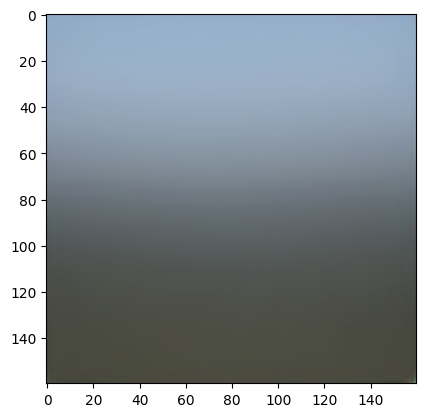

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 431ms/step
Epoch 19/100
1/1 [==============================] - 0s 29ms/step


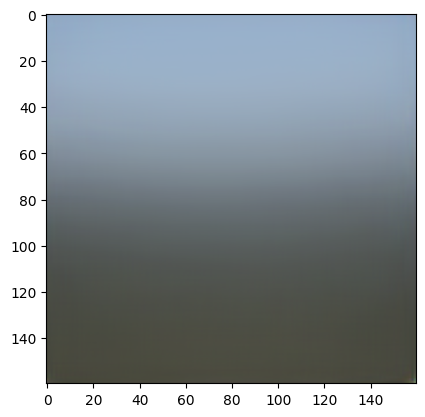

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 431ms/step
Epoch 20/100
1/1 [==============================] - 0s 20ms/step


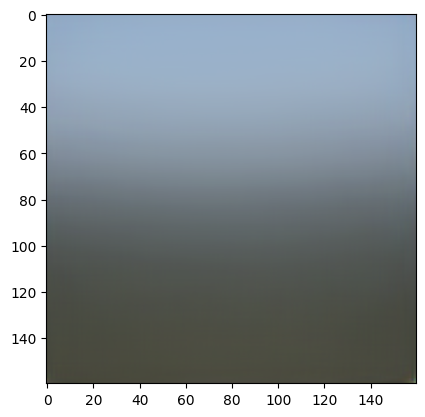

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 21/100
1/1 [==============================] - 0s 19ms/step


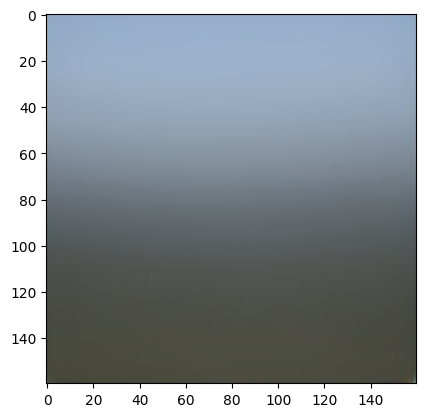

75/75 - 32s - loss: 0.0509 - val_loss: 0.0504 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 22/100
1/1 [==============================] - 0s 21ms/step


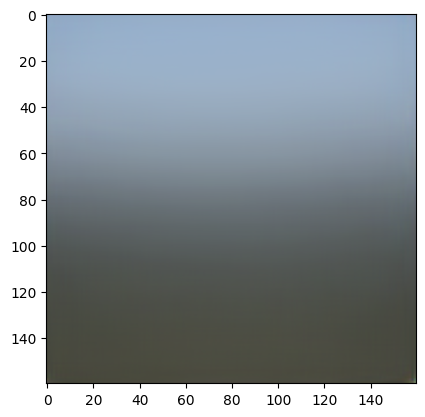

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 23/100
1/1 [==============================] - 0s 23ms/step


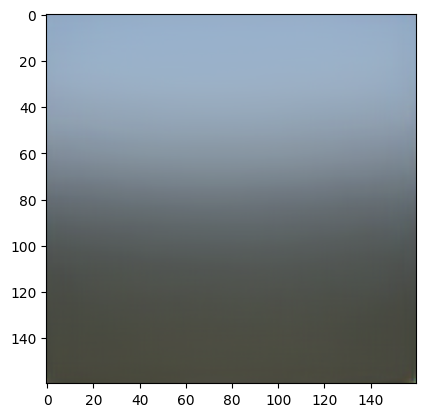

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 24/100
1/1 [==============================] - 0s 22ms/step


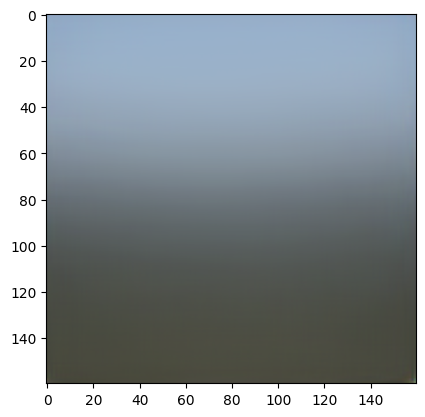

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 25/100
1/1 [==============================] - 0s 21ms/step


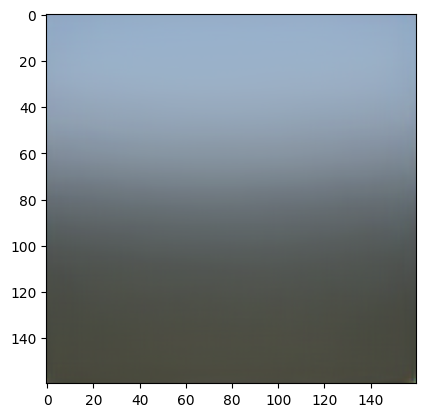

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 26/100
1/1 [==============================] - 0s 28ms/step


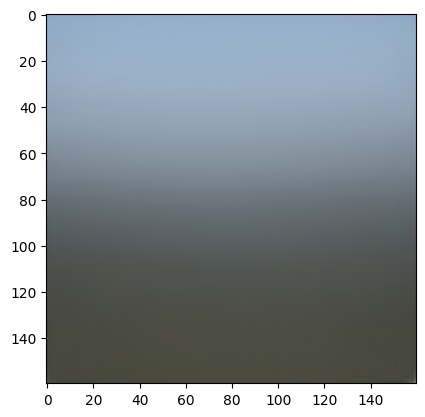

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 27/100
1/1 [==============================] - 0s 22ms/step


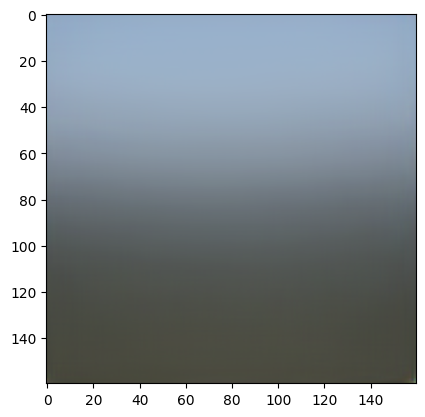

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 28/100
1/1 [==============================] - 0s 22ms/step


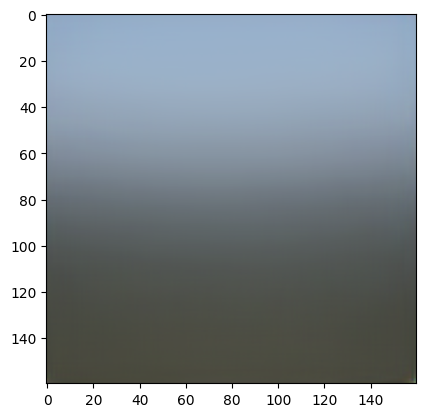

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 29/100
1/1 [==============================] - 0s 27ms/step


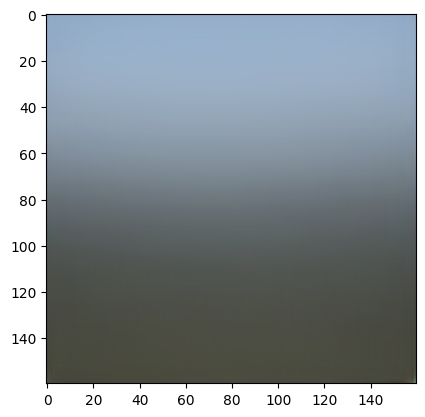

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 30/100
1/1 [==============================] - 0s 28ms/step


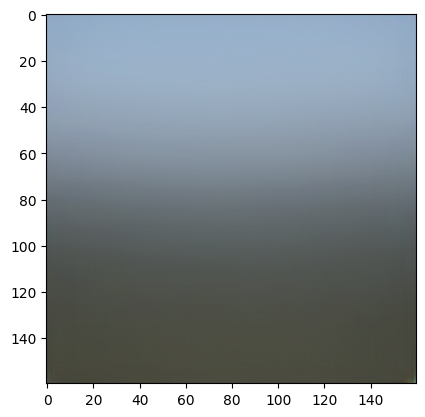

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 432ms/step
Epoch 31/100
1/1 [==============================] - 0s 20ms/step


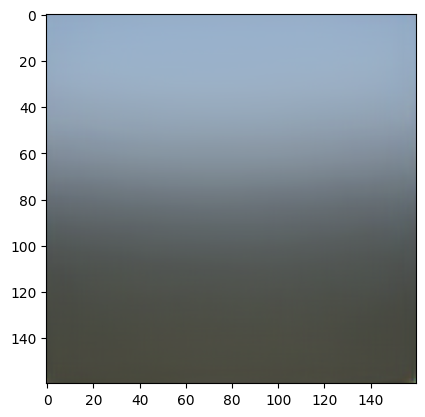

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 32/100
1/1 [==============================] - 0s 21ms/step


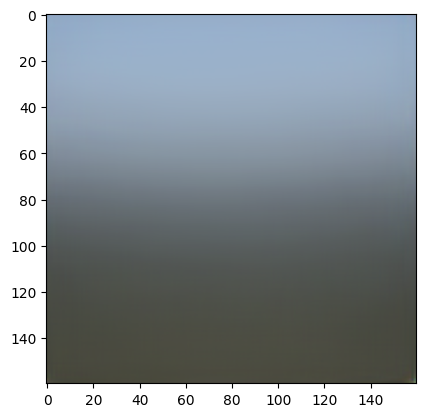

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 33/100
1/1 [==============================] - 0s 35ms/step


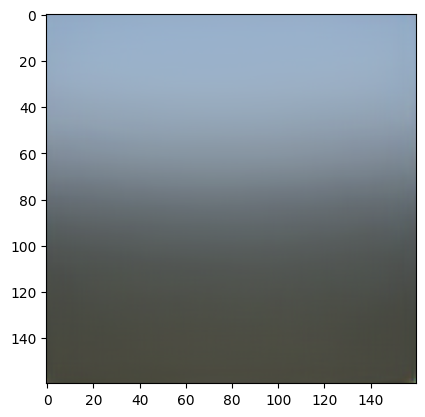

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 431ms/step
Epoch 34/100
1/1 [==============================] - 0s 19ms/step


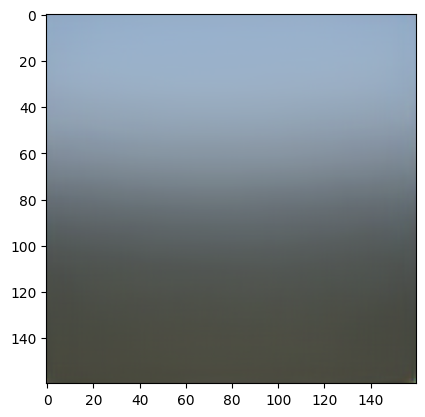

75/75 - 38s - loss: 0.0510 - val_loss: 0.0504 - lr: 1.0000e-05 - 38s/epoch - 502ms/step
Epoch 35/100
1/1 [==============================] - 0s 20ms/step


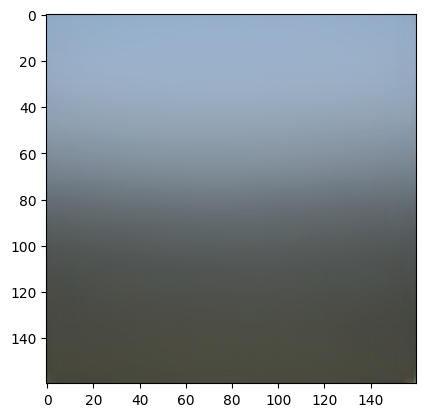

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 431ms/step
Epoch 36/100
1/1 [==============================] - 0s 24ms/step


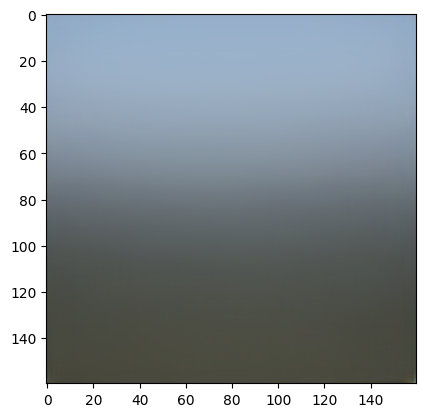

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 37/100
1/1 [==============================] - 0s 23ms/step


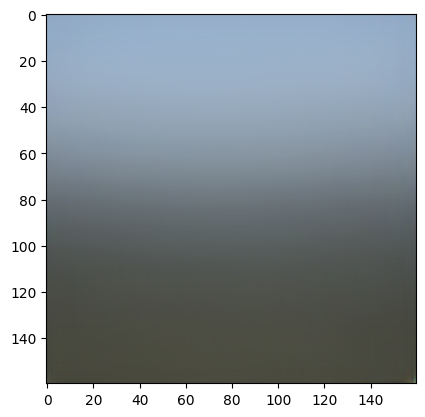

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 428ms/step
Epoch 38/100
1/1 [==============================] - 0s 19ms/step


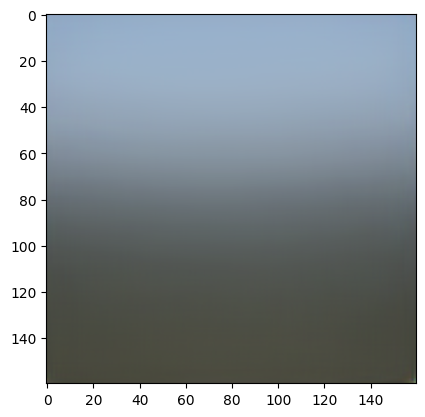

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 39/100
1/1 [==============================] - 0s 20ms/step


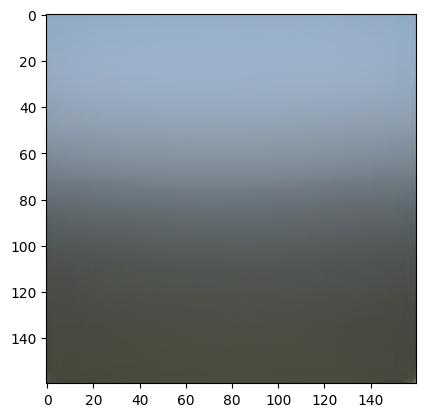

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 40/100
1/1 [==============================] - 0s 31ms/step


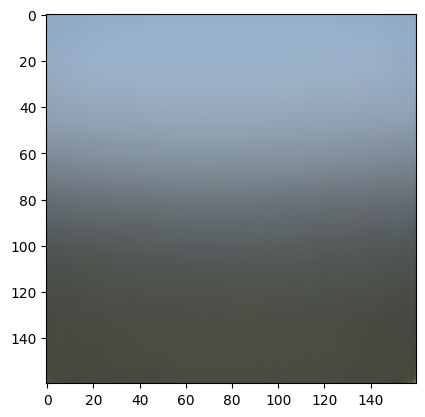

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 41/100
1/1 [==============================] - 0s 19ms/step


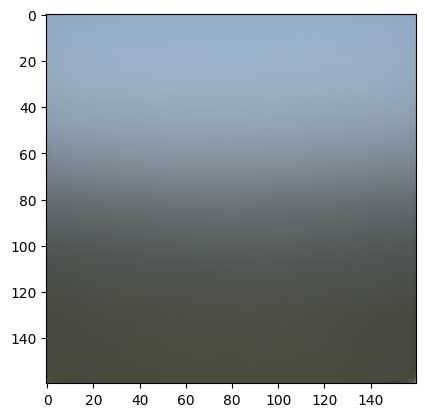

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 428ms/step
Epoch 42/100
1/1 [==============================] - 0s 21ms/step


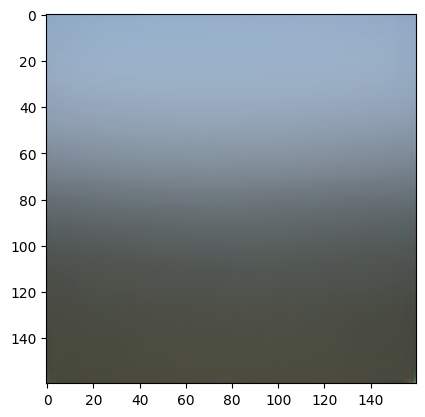

75/75 - 32s - loss: 0.0509 - val_loss: 0.0504 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 43/100
1/1 [==============================] - 0s 28ms/step


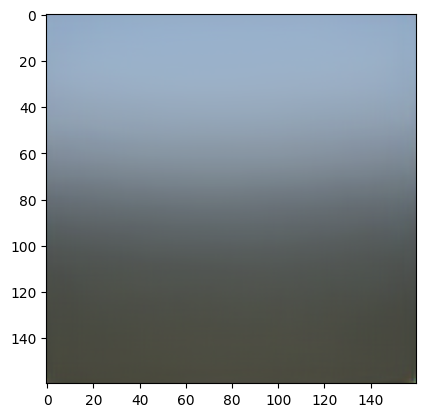

75/75 - 32s - loss: 0.0509 - val_loss: 0.0504 - lr: 1.0000e-05 - 32s/epoch - 433ms/step
Epoch 44/100
1/1 [==============================] - 0s 25ms/step


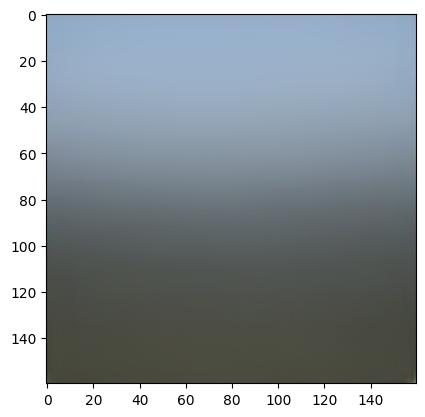

75/75 - 32s - loss: 0.0509 - val_loss: 0.0504 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 45/100
1/1 [==============================] - 0s 23ms/step


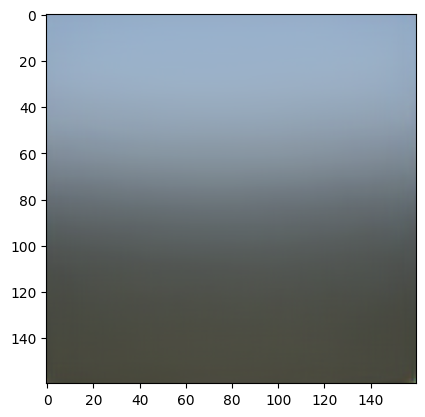

75/75 - 33s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 33s/epoch - 435ms/step
Epoch 46/100
1/1 [==============================] - 0s 31ms/step


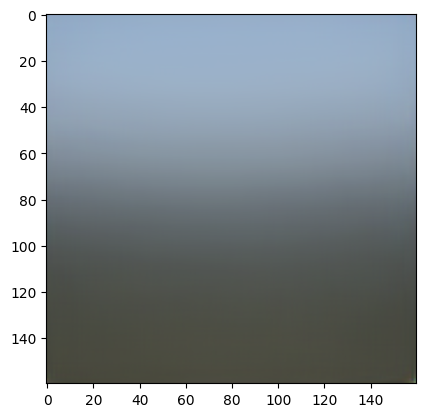

75/75 - 32s - loss: 0.0509 - val_loss: 0.0504 - lr: 1.0000e-05 - 32s/epoch - 432ms/step
Epoch 47/100
1/1 [==============================] - 0s 22ms/step


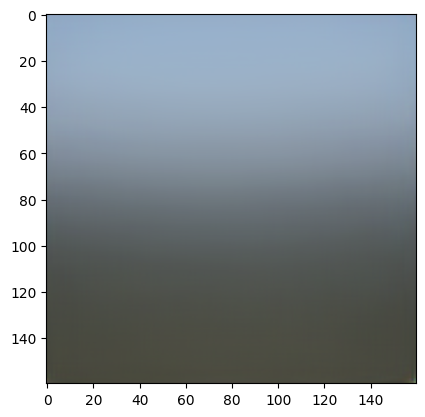

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 48/100
1/1 [==============================] - 0s 21ms/step


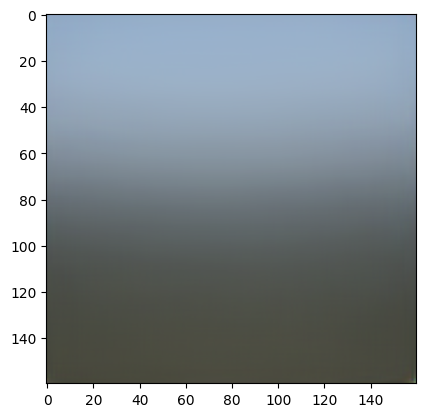

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 49/100
1/1 [==============================] - 0s 24ms/step


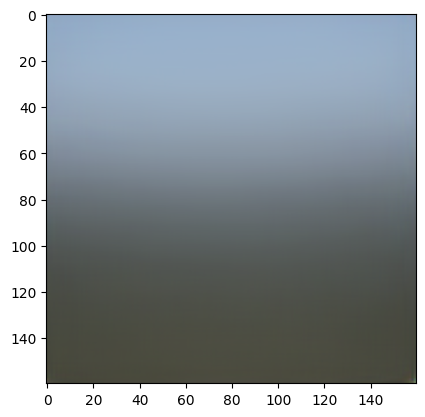

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 50/100
1/1 [==============================] - 0s 21ms/step


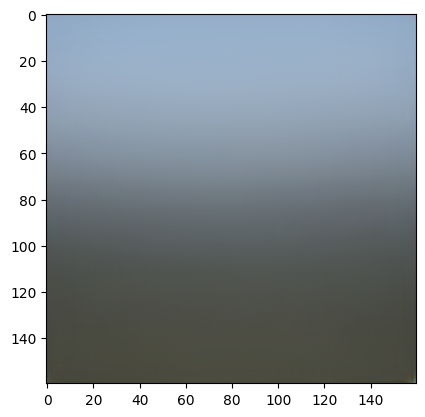

75/75 - 32s - loss: 0.0510 - val_loss: 0.0504 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 51/100
1/1 [==============================] - 0s 28ms/step


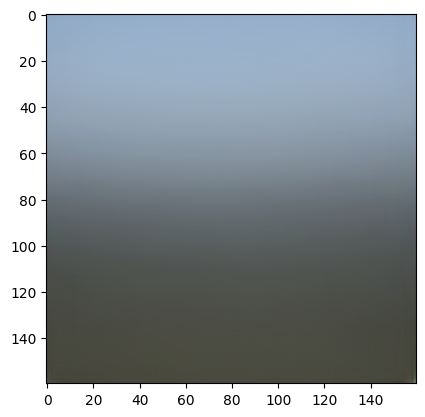

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 52/100
1/1 [==============================] - 0s 25ms/step


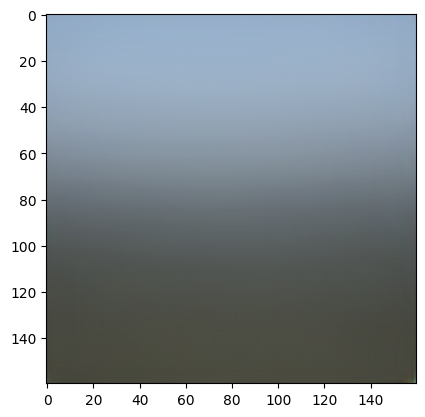

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 53/100
1/1 [==============================] - 0s 20ms/step


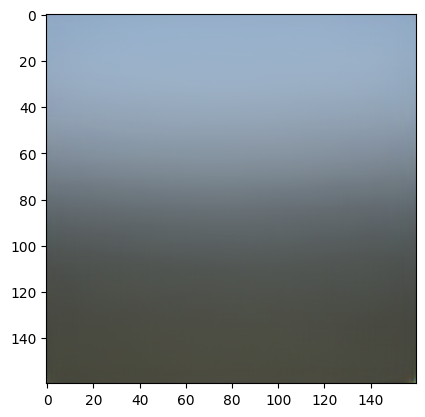

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 54/100
1/1 [==============================] - 0s 22ms/step


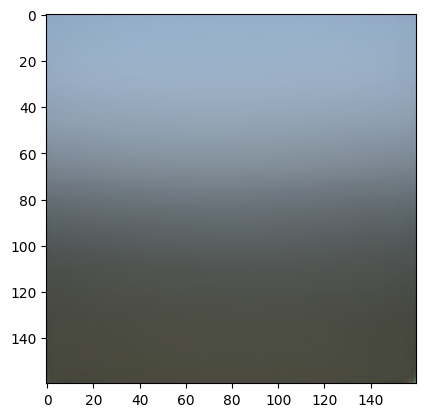

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 55/100
1/1 [==============================] - 0s 22ms/step


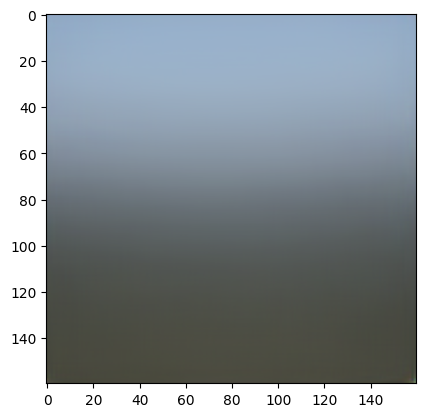

75/75 - 32s - loss: 0.0510 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 56/100
1/1 [==============================] - 0s 24ms/step


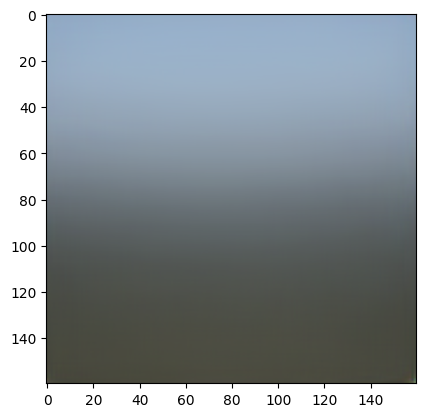

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 57/100
1/1 [==============================] - 0s 33ms/step


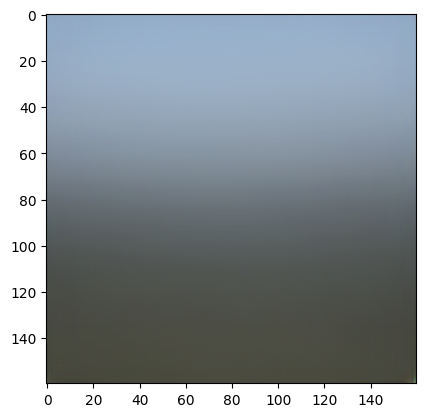

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 431ms/step
Epoch 58/100
1/1 [==============================] - 0s 20ms/step


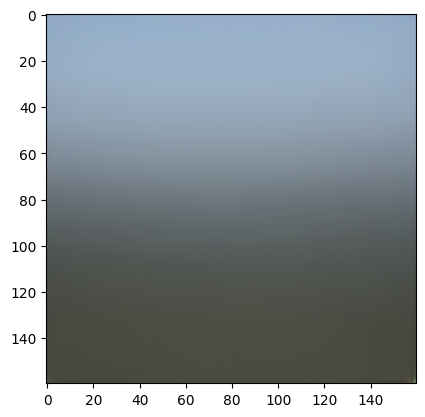

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 429ms/step
Epoch 59/100
1/1 [==============================] - 0s 21ms/step


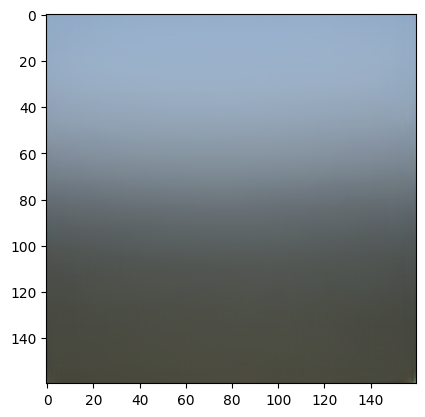

75/75 - 32s - loss: 0.0509 - val_loss: 0.0505 - lr: 1.0000e-05 - 32s/epoch - 430ms/step
Epoch 60/100


KeyboardInterrupt: ignored

In [22]:
print(xtrain.shape)
model.fit(xtrain, xtrain,
          epochs=100,
          batch_size=32,
          verbose=2,
          validation_split=0.05,
          callbacks=[learning_rate_reduction, checkpoint, early_stopping, imgsample])

79/79 [==============================] - 13s 163ms/step


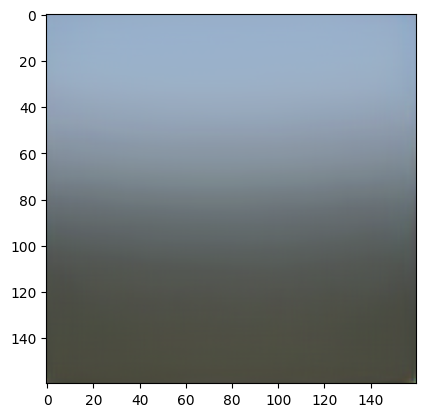

In [15]:
decoded_imgs = model.predict(xtrain)
plt.imshow(decoded_imgs[0])
plt.show()

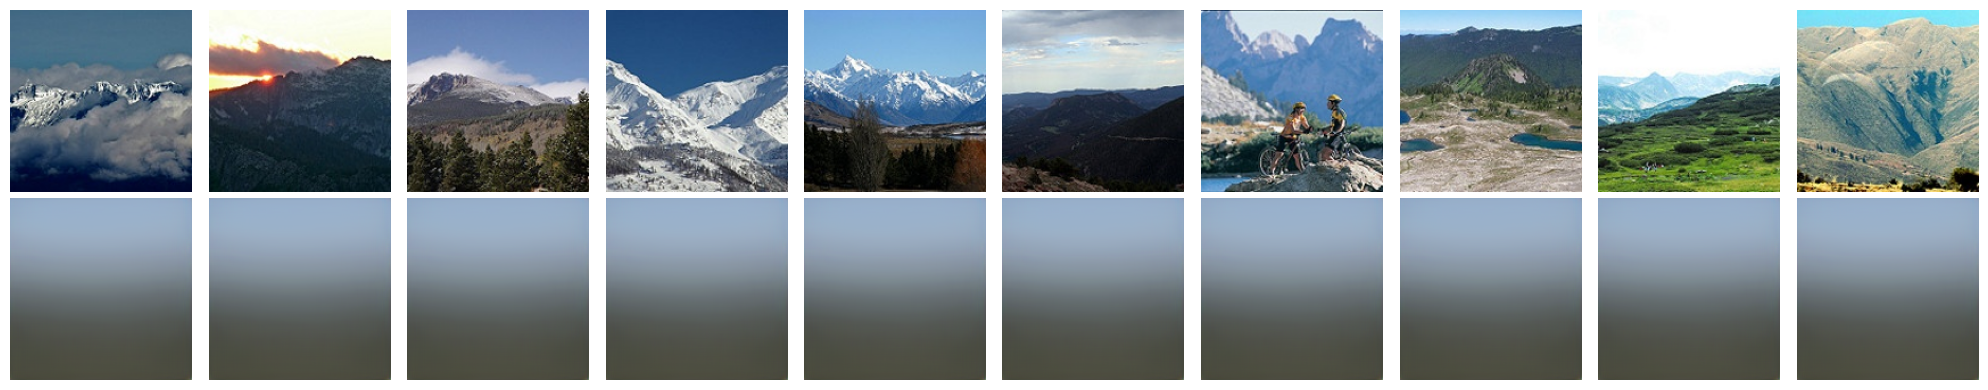

In [23]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # original
    plt.subplot(2, 10, i + 1)
    plt.imshow(xtrain[i])
    plt.axis('off')

    # reconstruction
    plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_imgs[i])
    plt.axis('off')

plt.tight_layout()
plt.show()